In [23]:
import os
import tarfile
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from zipfile import ZipFile

![](https://storage.googleapis.com/kaggle-datasets-images/1251943/2088085/480fac10e111e15e14ef6684cf9da7ea/dataset-cover.jpg?t=2021-04-05-08-15-10)

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

## 1. Download Data

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

download_path = "/content/aclImdb_v1.tar.gz"


response = requests.get(url)
with open(download_path, "wb") as f:
    f.write(response.content)

with tarfile.open(download_path, "r:gz") as tar:
    tar.extractall("/content/")

os.listdir("/content/aclImdb")

['test', 'train', 'README', 'imdb.vocab', 'imdbEr.txt']

## 2. Melihat contoh data

In [ ]:
dataset_path = '/content/aclImdb'

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

pos_dir = os.path.join(dataset_path, 'train', 'pos')
neg_dir = os.path.join(dataset_path, 'train', 'neg')

print("Contoh teks dengan review positif:")
for file_name in os.listdir(pos_dir)[:5]:
    file_path = os.path.join(pos_dir, file_name)
    text = read_text_file(file_path)
    print(f"Review: {text}\n")

print("\nContoh teks dengan review negatif:")
for file_name in os.listdir(neg_dir)[:5]:
    file_path = os.path.join(neg_dir, file_name)
    text = read_text_file(file_path)
    print(f"Review: {text}\n")

Contoh teks dengan review positif:
Review: This movie is actually FUNNY! If you'd like to rest your brain for an hour so then go ahead and watch it. It's called blonde and blonder, so don't expect profound and meaningful jokes. What this movie and enjoy all the stereotypes we have about two blondes. It's just a funny movie to watch on a date or with a company of friends (especially if you're not too sober. Lol ) Pamela and Denise are still pretty hot chicks. It's a mistake to judge this movie as a piece of art. C'mon, this movie is about BLONDES! It's supposed to be light, funny and superficial. One more thing, I do not think that girls will appreciate and like this movie but guy definitely will.

Review: Main theme in this Dirty Harry is that revenge is a dish best served cold. Sandra Locke is as cold in this film as she is beautiful. Locke is an "8" normally, but, with a deadly pistol in her purse, "cocked" for the bad guys, she climbs all the way up the scale to a "10". Having been 

In [ ]:
texts_train = []
labels_train = []
for label in ['pos', 'neg']:
    dir_name = os.path.join(dataset_path, 'train', label)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                texts_train.append(f.read())
            labels_train.append(1 if label == 'pos' else 0)

texts_test = []
labels_test = []
for label in ['pos', 'neg']:
    dir_name = os.path.join(dataset_path, 'test', label)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                texts_test.append(f.read())
            labels_test.append(1 if label == 'pos' else 0)

In [ ]:
texts = texts_train + texts_test
labels = labels_train + labels_test

In [30]:
print(f"Terdapat {len(texts)} data di dalam dataset")

Terdapat 50000 data di dalam dataset


In [ ]:
max_words = 1000
max_review_length = 300

tokenizer = Tokenizer(num_words=max_words, oov_token='<oov>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x = pad_sequences(sequences, maxlen=max_review_length, padding='post')
y = np.array(labels)

In [ ]:
# Split dataset menjadi train set dan validation set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# konversi ke tf tensor
x_train, x_val, y_train, y_val = tf.constant(x_train), tf.constant(x_val), tf.constant(y_train), tf.constant(y_val)

In [28]:
print(f"Terdapat {len(x_train)} sampel untuk data latih")
print(f"Terdapat {len(x_val)} sampel untuk data validasi")

Terdapat 40000 sampel untuk data latih
Terdapat 10000 sampel untuk data validasi


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_review_length),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(200),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           32000     
                                                                 
 lstm_2 (LSTM)               (None, 300, 100)          53200     
                                                                 
 lstm_3 (LSTM)               (None, 200)               240800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 326201 (1.24 MB)
Trainable params: 326201 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint_path = '/best_model.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


# Buat callback
class StopTrainingOnValidation(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.9:
            print("\nAkurasi validasi di atas 90%, berhenti melatih.")
            self.model.stop_training = True

class EarlyStoppingOnValidation(tf.keras.callbacks.Callback):
    def __init__(self, patience=10):
        super(EarlyStoppingOnValidation, self).__init__()
        self.patience = patience
        self.best_val_accuracy = -1
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs['val_accuracy']
        if current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nAkurasi validasi tidak meningkat selama {self.patience} epoch. Berhenti melatih.")
                self.model.stop_training = True

In [ ]:
callbacks = [checkpoint_callback, StopTrainingOnValidation(), EarlyStoppingOnValidation(patience=10)]
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, callbacks=callbacks)


Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.5109
Epoch 1: val_accuracy improved from -inf to 0.51400, saving model to /best_model.h5
313/313 [==============================] - 27s 71ms/step - loss: 0.6975 - accuracy: 0.5109 - val_loss: 0.6899 - val_accuracy: 0.5140
Epoch 2/100
  3/313 [..............................] - ETA: 14s - loss: 0.6979 - accuracy: 0.4688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5119
Epoch 2: val_accuracy improved from 0.51400 to 0.53850, saving model to /best_model.h5
313/313 [==============================] - 18s 57ms/step - loss: 0.6889 - accuracy: 0.5119 - val_loss: 0.6845 - val_accuracy: 0.5385
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.5444
Epoch 3: val_accuracy improved from 0.53850 to 0.54070, saving model to /best_model.h5
313/313 [==============================] - 17s 56ms/step - loss: 0.6758 - accuracy: 0.5444 - val_loss: 0.6770 - val_accuracy: 0.5407
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.5586
Epoch 4: val_accuracy improved from 0.54070 to 0.55070, saving model to /best_model.h5
313/313 [==============================] - 19s 62ms/step - loss: 0.6630 - accuracy: 0.5586 - val_loss: 0.6499 - val_accuracy: 0.5507
Epoch 5/100
313/313 [==============================] - ETA: 0

In [ ]:
train_accuracy = model.evaluate(x_train, y_train)[1]
val_accuracy = model.evaluate(x_val, y_val)[1]

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

313/313 [==============================] - 4s 12ms/step - loss: 0.3452 - accuracy: 0.8703
Train Accuracy: 93.84%
Validation Accuracy: 87.03%


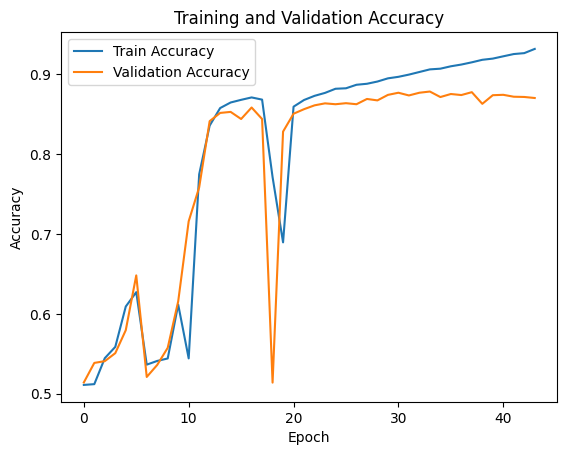

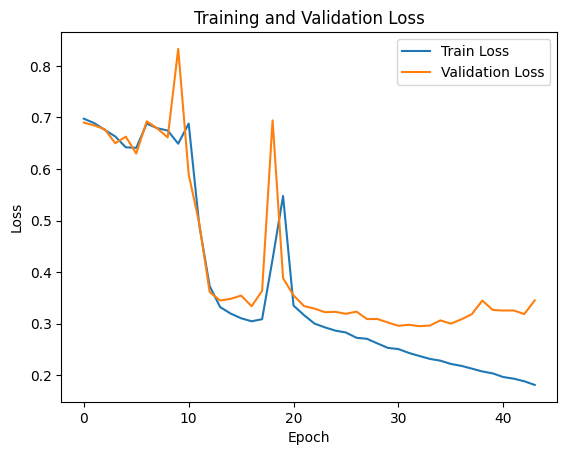

In [ ]:
# 9. Plot loss dan akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Project 1 : NLP dengan Tensorflow

Nama : Muhammad Ihsan

emhihsan@gmail.com